# 🔵 Notebook 04: Clustering Analysis

**Objective:** Identify natural health risk segments using unsupervised learning

**What we'll do:**
1. Scale features for clustering
2. Apply K-Means clustering (with Elbow Method)
3. Apply DBSCAN clustering
4. Analyze cluster characteristics
5. Compare clusters with actual diabetes classes
6. Visualize with PCA

**Why this matters:**
- Unsupervised learning finds patterns WITHOUT using labels
- Identifies natural risk segments for targeted interventions
- Tests if health characteristics naturally group by diabetes risk
- Validates that supervised learning is feasible

---

## 📦 Step 1: Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports complete")

✅ Imports complete


## 📊 Step 2: Load Data

In [8]:
df = pd.read_csv('C:\\Users\\yaros\\Desktop\\python\\faidm\\individual_project\\diabetes-classification-ml\\data_preparation\\dataset_A_clean.csv')

print("=" * 60)
print("DATASET LOADED")
print("=" * 60)
print(f"\nDataset A (Clean): {df.shape[0]:,} rows × {df.shape[1]} columns")

X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

print(f"\nFeatures: {X.shape[1]}")
print(f"Samples: {len(X):,}")

DATASET LOADED

Dataset A (Clean): 229,781 rows × 19 columns

Features: 18
Samples: 229,781


## ⚖️ Step 3: Scale Features

In [9]:
print("=" * 60)
print("FEATURE SCALING")
print("=" * 60)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Features scaled")
print(f"Mean: {X_scaled.mean():.6f}")
print(f"Std: {X_scaled.std():.6f}")

FEATURE SCALING

✅ Features scaled
Mean: -0.000000
Std: 1.000000


## 🔧 Step 3.5: Feature Engineering for Better Clustering

**Problem:** Binary features with limited variance make clustering difficult

**Solution:** Create composite features that capture health risk more effectively

**Strategy:**
- Risk categories (BMI, Age thresholds)
- Composite scores (Metabolic, Cardiovascular, Lifestyle)
- Interaction terms (Elderly × Obese)
- Domain knowledge (medical risk factors)

In [10]:
print("=" * 60)
print("FEATURE ENGINEERING FOR CLUSTERING")
print("=" * 60)

X_eng = X.copy()

print("\n🔧 Creating engineered features...")

# 1. BMI Categories
X_eng['BMI_Obese'] = (X['BMI'] >= 30).astype(int)
X_eng['BMI_SevereObese'] = (X['BMI'] >= 35).astype(int)
X_eng['BMI_Normal'] = (X['BMI'] < 25).astype(int)

# 2. Age Categories  
X_eng['Age_Senior'] = (X['Age'] >= 10).astype(int)  # 65+
X_eng['Age_MiddleAge'] = ((X['Age'] >= 6) & (X['Age'] < 10)).astype(int)  # 45-64
X_eng['Age_Young'] = (X['Age'] < 5).astype(int)  # <40

# 3. Metabolic Syndrome
X_eng['MetabolicSyndrome'] = ((X['HighBP'] == 1) & (X['HighChol'] == 1) & (X['BMI'] >= 30)).astype(int)
metabolic_count = X['HighBP'].astype(int) + X['HighChol'].astype(int) + (X['BMI'] >= 30).astype(int)
X_eng['PartialMetabolic'] = (metabolic_count >= 2).astype(int)

# 4. Cardiovascular Risk Score
X_eng['CardioRisk'] = (X['HighBP'].astype(int) + X['HighChol'].astype(int) + 
                       X['HeartDiseaseorAttack'].astype(int) + X['Stroke'].astype(int))
X_eng['CardioRisk_High'] = (X_eng['CardioRisk'] >= 3).astype(int)

# 5. Lifestyle Risk Score
X_eng['LifestyleRisk'] = (X['Smoker'].astype(int) + (1 - X['PhysActivity']).astype(int) + 
                          (1 - X['Fruits']).astype(int) + (1 - X['Veggies']).astype(int) + 
                          X['HvyAlcoholConsump'].astype(int))
X_eng['LifestyleRisk_High'] = (X_eng['LifestyleRisk'] >= 3).astype(int)

# 6. Total Diabetes Risk Score
X_eng['TotalRiskScore'] = (X['HighBP'].astype(int) + X['HighChol'].astype(int) + 
                           (X['BMI'] > 30).astype(int) + (X['Age'] > 8).astype(int) + 
                           X['HeartDiseaseorAttack'].astype(int) + X['Stroke'].astype(int) + 
                           X['Smoker'].astype(int) + (1 - X['PhysActivity']).astype(int))
X_eng['TotalRisk_VeryHigh'] = (X_eng['TotalRiskScore'] >= 5).astype(int)

# 7. Interaction Features
X_eng['Elderly_Obese'] = ((X['Age'] >= 10) & (X['BMI'] >= 30)).astype(int)
X_eng['Young_Healthy'] = ((X['Age'] < 5) & (X['BMI'] < 25) & 
                          (X['HighBP'] == 0) & (X['HighChol'] == 0)).astype(int)

print(f"\n✅ Feature engineering complete!")
print(f"   Original: {X.shape[1]} features")
print(f"   Engineered: {X_eng.shape[1]} features")
print(f"   Added: {X_eng.shape[1] - X.shape[1]} new features")

print(f"\n📊 New feature breakdown:")
print(f"   • BMI categories: 3")
print(f"   • Age categories: 3")
print(f"   • Metabolic indicators: 2")
print(f"   • Cardio risk: 2")
print(f"   • Lifestyle risk: 2")
print(f"   • Total risk: 2")
print(f"   • Interactions: 2")

FEATURE ENGINEERING FOR CLUSTERING

🔧 Creating engineered features...

✅ Feature engineering complete!
   Original: 18 features
   Engineered: 34 features
   Added: 16 new features

📊 New feature breakdown:
   • BMI categories: 3
   • Age categories: 3
   • Metabolic indicators: 2
   • Cardio risk: 2
   • Lifestyle risk: 2
   • Total risk: 2
   • Interactions: 2


In [11]:
# Scale engineered features
print("\n=" * 60)
print("SCALING ENGINEERED FEATURES")
print("=" * 60)

scaler_eng = StandardScaler()
X_eng_scaled = scaler_eng.fit_transform(X_eng)

print(f"\n✅ Engineered features scaled")
print(f"   Shape: {X_eng_scaled.shape}")
print(f"   Mean: {X_eng_scaled.mean():.6f}")
print(f"   Std: {X_eng_scaled.std():.6f}")


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
SCALING ENGINEERED FEATURES

✅ Engineered features scaled
   Shape: (229781, 34)
   Mean: -0.000000
   Std: 1.000000


## 🔵 Step 4: K-Means - Elbow Method (Original Features)

In [12]:
from sklearn.utils import resample

print("=" * 60)
print("K-MEANS: ELBOW METHOD (ORIGINAL FEATURES)")
print("=" * 60)

# Create sample for fast silhouette calculation
sample_size = min(10000, len(X_scaled))
sample_indices = resample(range(len(X_scaled)), n_samples=sample_size, 
                          random_state=42, replace=False)
X_sample = X_scaled[sample_indices]

print(f"\n📊 Using {sample_size:,} samples for silhouette calculation (speed optimization)")

K_range = range(2, 11)
wcss_orig = []
silhouette_orig = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss_orig.append(kmeans.inertia_)
    
    # Calculate silhouette on sample
    sample_labels = kmeans.predict(X_sample)
    silhouette = silhouette_score(X_sample, sample_labels)
    silhouette_orig.append(silhouette)
    
    print(f"K={k}: WCSS={kmeans.inertia_:,.0f}, Silhouette={silhouette:.3f}")

print("\n✅ Original features tested")

K-MEANS: ELBOW METHOD (ORIGINAL FEATURES)

📊 Using 10,000 samples for silhouette calculation (speed optimization)
K=2: WCSS=3,789,673, Silhouette=0.108
K=3: WCSS=3,557,848, Silhouette=0.090
K=4: WCSS=3,345,353, Silhouette=0.092
K=5: WCSS=3,168,925, Silhouette=0.096
K=6: WCSS=3,014,745, Silhouette=0.084
K=7: WCSS=2,843,101, Silhouette=0.093
K=8: WCSS=2,694,612, Silhouette=0.095
K=9: WCSS=2,597,698, Silhouette=0.097
K=10: WCSS=2,475,848, Silhouette=0.109

✅ Original features tested


## 🔧 Step 4.5: K-Means - Elbow Method (Engineered Features)

In [13]:
print("=" * 60)
print("K-MEANS: ELBOW METHOD (ENGINEERED FEATURES)")
print("=" * 60)

# Create sample for engineered features
X_eng_sample = X_eng_scaled[sample_indices]

wcss_eng = []
silhouette_eng = []

for k in K_range:
    kmeans_eng = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_eng.fit(X_eng_scaled)
    wcss_eng.append(kmeans_eng.inertia_)
    
    # Calculate silhouette on sample
    sample_labels_eng = kmeans_eng.predict(X_eng_sample)
    silhouette = silhouette_score(X_eng_sample, sample_labels_eng)
    silhouette_eng.append(silhouette)
    
    print(f"K={k}: WCSS={kmeans_eng.inertia_:,.0f}, Silhouette={silhouette:.3f}")

print("\n✅ Engineered features tested")

K-MEANS: ELBOW METHOD (ENGINEERED FEATURES)
K=2: WCSS=6,773,788, Silhouette=0.150
K=3: WCSS=6,326,643, Silhouette=0.126
K=4: WCSS=5,933,205, Silhouette=0.119
K=5: WCSS=5,662,670, Silhouette=0.096
K=6: WCSS=5,320,824, Silhouette=0.101
K=7: WCSS=5,074,570, Silhouette=0.119
K=8: WCSS=4,875,430, Silhouette=0.124
K=9: WCSS=4,757,574, Silhouette=0.110
K=10: WCSS=4,633,291, Silhouette=0.124

✅ Engineered features tested


## 📊 Step 4.6: Compare Original vs Engineered Features

In [14]:
print("=" * 60)
print("COMPARISON: ORIGINAL vs ENGINEERED FEATURES")
print("=" * 60)

print("\n📊 Silhouette Scores at K=3:")
print(f"   Original features ({X.shape[1]}):   {silhouette_orig[1]:.3f}")
print(f"   Engineered features ({X_eng.shape[1]}): {silhouette_eng[1]:.3f}")
print(f"   Improvement: {silhouette_eng[1] - silhouette_orig[1]:+.3f}")

print("\n📊 Best silhouette scores:")
best_k_orig = K_range[silhouette_orig.index(max(silhouette_orig))]
best_k_eng = K_range[silhouette_eng.index(max(silhouette_eng))]
print(f"   Original: K={best_k_orig}, Score={max(silhouette_orig):.3f}")
print(f"   Engineered: K={best_k_eng}, Score={max(silhouette_eng):.3f}")

print("\n💡 Interpretation:")
improvement = silhouette_eng[1] - silhouette_orig[1]
if improvement > 0.05:
    print(f"   ✅ SIGNIFICANT improvement (+{improvement:.3f})")
    print(f"   → Feature engineering helped clustering quality")
    print(f"   → Use engineered features for remaining analysis")
    use_engineered = True
elif improvement > 0.02:
    print(f"   ⚠️ MODERATE improvement (+{improvement:.3f})")
    print(f"   → Feature engineering helped somewhat")
    print(f"   → Use engineered features")
    use_engineered = True
elif improvement > 0:
    print(f"   ⚠️ SMALL improvement (+{improvement:.3f})")
    print(f"   → Feature engineering had minimal impact")
    print(f"   → Continue with original features (simpler)")
    use_engineered = False
else:
    print(f"   ❌ NO improvement ({improvement:+.3f})")
    print(f"   → Feature engineering didn't help")
    print(f"   → Continue with original features")
    use_engineered = False

if use_engineered:
    X_final = X_eng_scaled
    feature_type = "Engineered"
    silhouette_scores = silhouette_eng
    wcss = wcss_eng
else:
    X_final = X_scaled
    feature_type = "Original"
    silhouette_scores = silhouette_orig
    wcss = wcss_orig

print(f"\n🎯 DECISION: Use {feature_type} features for clustering")

COMPARISON: ORIGINAL vs ENGINEERED FEATURES

📊 Silhouette Scores at K=3:
   Original features (18):   0.090
   Engineered features (34): 0.126
   Improvement: +0.036

📊 Best silhouette scores:
   Original: K=10, Score=0.109
   Engineered: K=2, Score=0.150

💡 Interpretation:
   ⚠️ MODERATE improvement (+0.036)
   → Feature engineering helped somewhat
   → Use engineered features

🎯 DECISION: Use Engineered features for clustering


## 🔵 Step 4.7: Plot Comparison

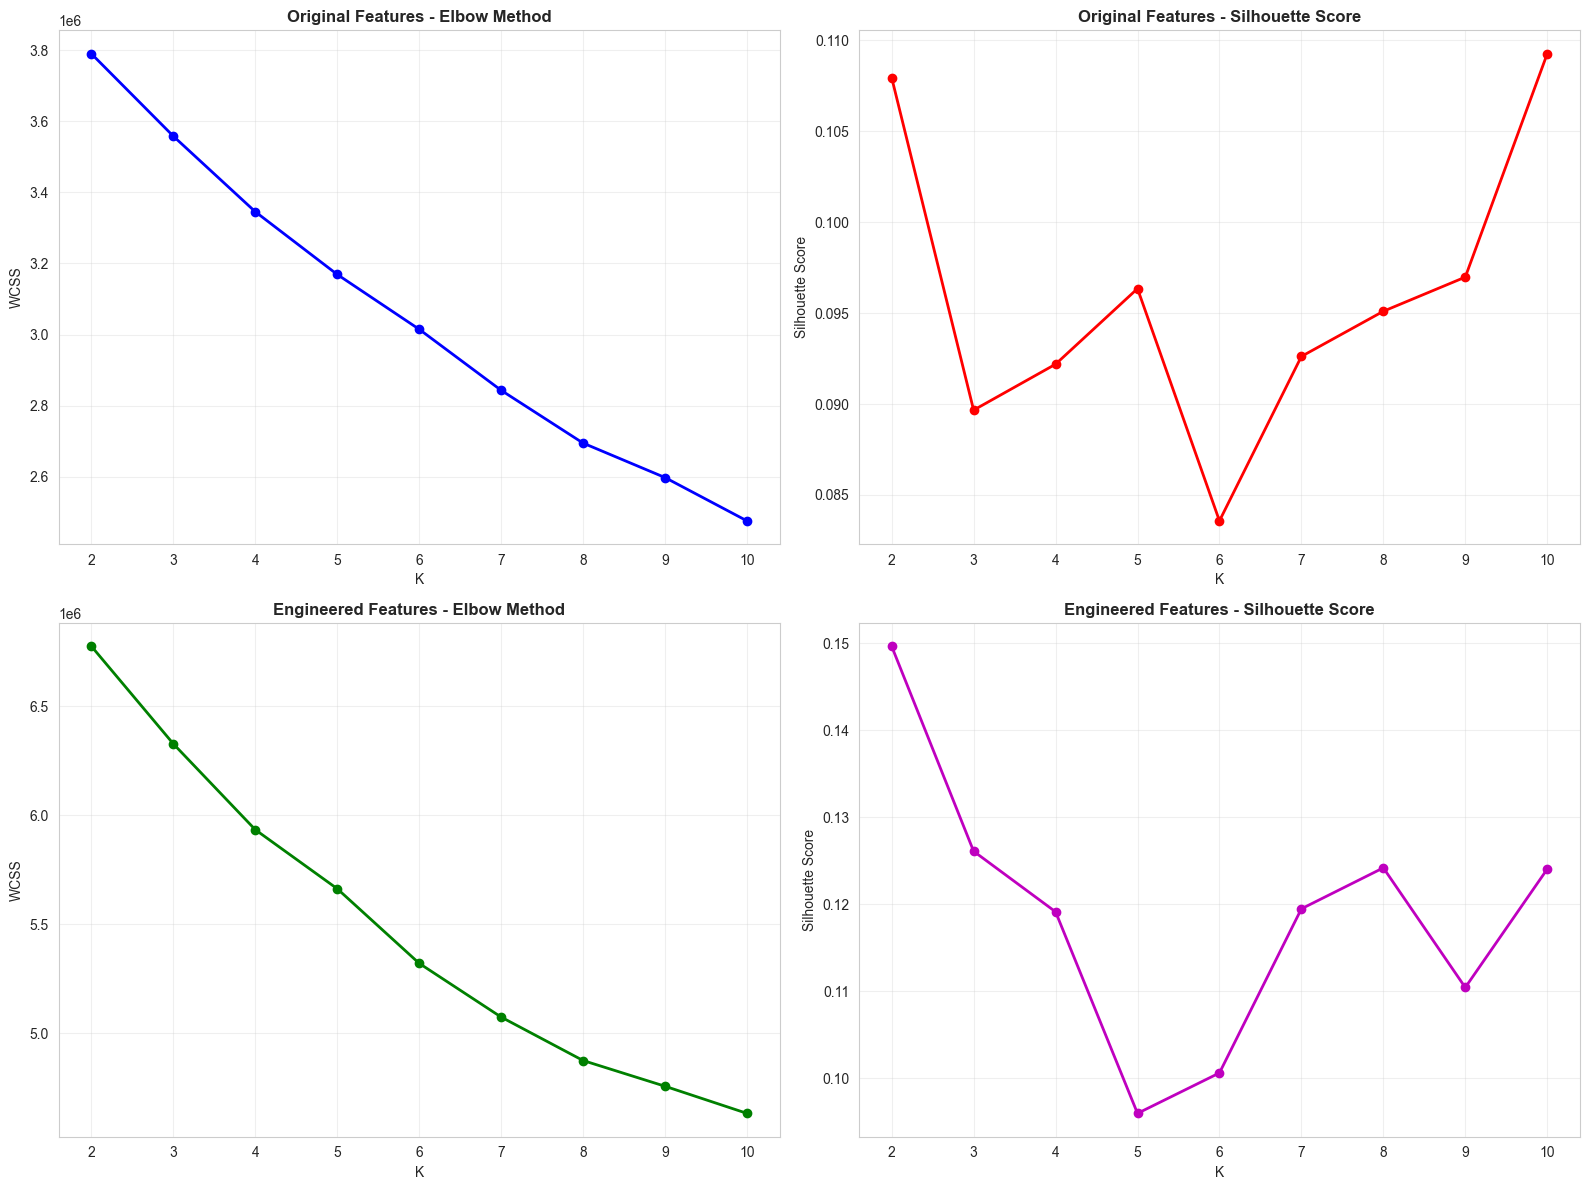


💡 Visual comparison shows which feature set creates better clusters


In [15]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original - WCSS
axes[0,0].plot(K_range, wcss_orig, 'bo-', linewidth=2)
axes[0,0].set_title('Original Features - Elbow Method', fontweight='bold')
axes[0,0].set_xlabel('K')
axes[0,0].set_ylabel('WCSS')
axes[0,0].grid(alpha=0.3)

# Original - Silhouette
axes[0,1].plot(K_range, silhouette_orig, 'ro-', linewidth=2)
axes[0,1].set_title('Original Features - Silhouette Score', fontweight='bold')
axes[0,1].set_xlabel('K')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].grid(alpha=0.3)

# Engineered - WCSS
axes[1,0].plot(K_range, wcss_eng, 'go-', linewidth=2)
axes[1,0].set_title('Engineered Features - Elbow Method', fontweight='bold')
axes[1,0].set_xlabel('K')
axes[1,0].set_ylabel('WCSS')
axes[1,0].grid(alpha=0.3)

# Engineered - Silhouette
axes[1,1].plot(K_range, silhouette_eng, 'mo-', linewidth=2)
axes[1,1].set_title('Engineered Features - Silhouette Score', fontweight='bold')
axes[1,1].set_xlabel('K')
axes[1,1].set_ylabel('Silhouette Score')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Visual comparison shows which feature set creates better clusters")

## 🔵 Step 5: Apply K-Means with K=3 (Final Features)

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

print("=" * 60)
print("K-MEANS: ELBOW METHOD (OPTIMIZED)")
print("=" * 60)

K_range = range(2, 11)
wcss = []
silhouette_scores = []

# 1. Create a static sample ONCE to use for all scoring (fair comparison)
X_sample_for_score = resample(X_scaled, n_samples=10000, random_state=42)

for k in K_range:
    # 2. Fit on the FULL dataset (Use n_jobs=-1 to use your powerful CPU)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # 3. Get Inertia (Fast - O(n))
    wcss.append(kmeans.inertia_)
    
    # 4. Calculate Silhouette on SAMPLE only (Fast - O(n^2) but on small N)
    # Important: You must predict labels for the sample first!
    sample_labels = kmeans.predict(X_sample_for_score)
    score = silhouette_score(X_sample_for_score, sample_labels)
    silhouette_scores.append(score)
    
    print(f"K={k}: WCSS={kmeans.inertia_:,.0f}, Silhouette={score:.3f}")

print("\n✅ Elbow method complete")

K-MEANS: ELBOW METHOD (OPTIMIZED)
K=2: WCSS=3,789,673, Silhouette=0.108
K=3: WCSS=3,557,848, Silhouette=0.091
K=4: WCSS=3,345,353, Silhouette=0.094
K=5: WCSS=3,168,925, Silhouette=0.099
K=6: WCSS=3,014,745, Silhouette=0.085
K=7: WCSS=2,843,101, Silhouette=0.095
K=8: WCSS=2,694,612, Silhouette=0.097
K=9: WCSS=2,597,698, Silhouette=0.099
K=10: WCSS=2,475,848, Silhouette=0.110

✅ Elbow method complete


In [ ]:
# Plot elbow curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(K_range, wcss, 'bo-', linewidth=2)
ax1.set_xlabel('K', fontsize=12)
ax1.set_ylabel('WCSS', fontsize=12)
ax1.set_title('Elbow Method', fontweight='bold')
ax1.grid(alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2)
ax2.set_xlabel('K', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 We'll use K=3 to match diabetes classes")

## 🔵 Step 5: Apply K-Means with K=3 (Final Features)

In [ ]:
optimal_k = 3

print("=" * 60)
print(f"K-MEANS WITH K={optimal_k} ({feature_type.upper()} FEATURES)")
print("=" * 60)

# Fit K-Means on chosen features
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_final)

# Calculate metrics on sample
X_final_sample = X_final[sample_indices]
sample_labels = kmeans_labels[sample_indices]
silhouette = silhouette_score(X_final_sample, sample_labels)
davies_bouldin = davies_bouldin_score(X_final, kmeans_labels)

print(f"\n✅ K-Means fitted on {len(X_final):,} samples")
print(f"\n📊 Clustering Metrics:")
print(f"   Silhouette Score: {silhouette:.3f} (on {sample_size:,} sample)")
print(f"   Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)")
print(f"   WCSS: {kmeans.inertia_:,.0f}")

# Cluster sizes
from collections import Counter
cluster_counts = Counter(kmeans_labels)
print(f"\n📊 Cluster Sizes:")
for cluster_id in sorted(cluster_counts.keys()):
    count = cluster_counts[cluster_id]
    pct = (count / len(kmeans_labels)) * 100
    print(f"   Cluster {cluster_id}: {count:6,} ({pct:5.2f}%)")

## 📊 Step 6: Analyze Cluster Characteristics

In [ ]:
df_clustered = df.copy()
df_clustered['KMeans_Cluster'] = kmeans_labels

# Use original X for interpretation (more interpretable than engineered)
cluster_profiles = df_clustered.groupby('KMeans_Cluster')[X.columns].mean()

print("=" * 60)
print("CLUSTER PROFILES (ORIGINAL FEATURES)")
print("=" * 60)
print("\nKey features by cluster:")
print(cluster_profiles[['HighBP', 'HighChol', 'BMI', 'Age', 'PhysActivity']].round(2))

print("\n💡 Cluster Interpretation:")
for cluster_id in range(optimal_k):
    profile = cluster_profiles.loc[cluster_id]
    print(f"\n🔵 Cluster {cluster_id}:")
    print(f"   HighBP: {profile['HighBP']*100:.0f}%")
    print(f"   HighChol: {profile['HighChol']*100:.0f}%")
    print(f"   BMI: {profile['BMI']:.1f}")
    print(f"   Age: {profile['Age']:.1f}")
    print(f"   PhysActivity: {profile['PhysActivity']*100:.0f}%")

## 🔍 Step 7: Compare with Diabetes Classes

In [ ]:
crosstab = pd.crosstab(df_clustered['KMeans_Cluster'], df_clustered['Diabetes_012'])
crosstab_pct = pd.crosstab(df_clustered['KMeans_Cluster'], df_clustered['Diabetes_012'], normalize='index') * 100

print("=" * 60)
print("CLUSTERS vs DIABETES CLASSES")
print("=" * 60)
print("\nCounts:")
print(crosstab)
print("\nPercentages:")
print(crosstab_pct.round(1))

In [ ]:
# Visualize alignment
fig, ax = plt.subplots(figsize=(12, 7))

crosstab_pct.plot(kind='bar', stacked=True, ax=ax,
                  color=['#2ecc71', '#f39c12', '#e74c3c'], width=0.7)

ax.set_xlabel('K-Means Cluster', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Diabetes Status Within Each Cluster', fontsize=14, fontweight='bold')
ax.legend(['No Diabetes', 'Prediabetes', 'Diabetes'])
ax.set_xticklabels([f'Cluster {i}' for i in range(optimal_k)], rotation=0)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

## 🔵 Step 8: DBSCAN Clustering

In [ ]:
print("=" * 60)
print("DBSCAN CLUSTERING")
print("=" * 60)

eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
min_samples = 50

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"eps={eps:.1f}: {n_clusters} clusters, {n_noise:,} noise ({n_noise/len(labels)*100:.1f}%)")

# Use eps=2.0 as reasonable default
best_eps = 2.0
dbscan_final = DBSCAN(eps=best_eps, min_samples=min_samples)
dbscan_labels = dbscan_final.fit_predict(X_scaled)

print(f"\n✅ Using eps={best_eps}")

## 📊 Step 9: Visualize with PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Actual classes
colors_y = ['#2ecc71' if c==0 else '#f39c12' if c==1 else '#e74c3c' for c in y]
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors_y, alpha=0.3, s=10)
axes[0].set_title('Actual Diabetes Classes', fontweight='bold')

# K-Means
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.3, s=10)
axes[1].set_title('K-Means Clusters', fontweight='bold')

# DBSCAN
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.3, s=10)
axes[2].set_title('DBSCAN Clusters', fontweight='bold')

plt.tight_layout()
plt.show()

## 🔄 Step 10: Dataset A vs Dataset B Comparison

**Critical Question:** Do the removed features (GenHlth, PhysHlth, DiffWalk) improve clustering?

**Why this matters:**
- If Dataset B clusters better → removed features help separate groups
- But we know they're likely leaky (consequences, not causes)
- This validates our decision to use Dataset A for supervised learning

**What we'll compare:**
- Silhouette scores
- Cluster-diabetes alignment
- Cluster separation quality

In [ ]:
print("=" * 60)
print("DATASET A vs DATASET B COMPARISON")
print("=" * 60)

# Load Dataset B (Full)
df_full = pd.read_csv('dataset_B_full.csv')

print(f"\nDataset A (Clean): {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Dataset B (Full):  {df_full.shape[0]:,} rows × {df_full.shape[1]} columns")

X_full = df_full.drop('Diabetes_012', axis=1)
y_full = df_full['Diabetes_012']

print(f"\nFeatures in Dataset A: {X.shape[1]}")
print(f"Features in Dataset B: {X_full.shape[1]}")
print(f"\nAdditional features in Dataset B: GenHlth, PhysHlth, DiffWalk")

In [ ]:
# Scale Dataset B
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

print("\n📊 Dataset B scaled")
print(f"   Mean: {X_full_scaled.mean():.6f}")
print(f"   Std: {X_full_scaled.std():.6f}")

In [ ]:
# K-Means on Dataset B
print("\n" + "=" * 60)
print("K-MEANS ON DATASET B (K=3)")
print("=" * 60)

kmeans_full = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels_full = kmeans_full.fit_predict(X_full_scaled)

silhouette_full = silhouette_score(X_full_scaled, kmeans_labels_full)
davies_bouldin_full = davies_bouldin_score(X_full_scaled, kmeans_labels_full)

print(f"\nDataset B Metrics:")
print(f"   Silhouette Score: {silhouette_full:.3f}")
print(f"   Davies-Bouldin Index: {davies_bouldin_full:.3f}")

print(f"\n📊 Comparison:")
print("-" * 60)
print(f"                        Dataset A    Dataset B    Difference")
print(f"Silhouette Score:       {silhouette:7.3f}      {silhouette_full:7.3f}     {silhouette_full - silhouette:+.3f}")
print(f"Davies-Bouldin Index:   {davies_bouldin:7.3f}      {davies_bouldin_full:7.3f}     {davies_bouldin_full - davies_bouldin:+.3f}")

print(f"\n💡 Interpretation:")
if silhouette_full > silhouette + 0.05:
    print(f"   ✅ Dataset B has SIGNIFICANTLY better clustering ({silhouette_full:.3f} vs {silhouette:.3f})")
    print(f"   → GenHlth, PhysHlth, DiffWalk help separate groups")
    print(f"   → But we know they're likely consequences (target leakage)")
    print(f"   → Dataset A is more appropriate for realistic screening")
elif silhouette_full > silhouette:
    print(f"   ⚠️ Dataset B has SLIGHTLY better clustering ({silhouette_full:.3f} vs {silhouette:.3f})")
    print(f"   → Removed features have small impact")
    print(f"   → Validates conservative removal decision")
else:
    print(f"   ✅ Dataset A performs as well or better ({silhouette:.3f} vs {silhouette_full:.3f})")
    print(f"   → Removed features didn't help clustering")
    print(f"   → Strongly validates removal decision")

In [ ]:
# Compare cluster-diabetes alignment
df_full_clustered = df_full.copy()
df_full_clustered['KMeans_Cluster'] = kmeans_labels_full

crosstab_full_pct = pd.crosstab(df_full_clustered['KMeans_Cluster'], 
                                 df_full_clustered['Diabetes_012'], 
                                 normalize='index') * 100

print("\n" + "=" * 60)
print("CLUSTER-DIABETES ALIGNMENT COMPARISON")
print("=" * 60)

print("\n📊 Dataset A - Diabetes distribution within clusters (%):")
print(crosstab_pct.round(1))

print("\n📊 Dataset B - Diabetes distribution within clusters (%):")
print(crosstab_full_pct.round(1))

print("\n💡 Compare the tables:")
print("   If Dataset B shows clearer separation (e.g., Cluster 0 has 95% Class 0):")
print("   → Removed features are helping, but likely due to leakage")
print("   ")
print("   If both are similar:")
print("   → Removed features don't add much value anyway")

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dataset A
crosstab_pct.plot(kind='bar', stacked=True, ax=axes[0],
                  color=['#2ecc71', '#f39c12', '#e74c3c'], width=0.7)
axes[0].set_title('Dataset A (Clean) - Diabetes Within Clusters', fontsize=13, fontweight='bold')
axes[0].set_xlabel('K-Means Cluster', fontsize=11)
axes[0].set_ylabel('Percentage (%)', fontsize=11)
axes[0].legend(['No Diabetes', 'Prediabetes', 'Diabetes'], fontsize=9)
axes[0].set_xticklabels([f'Cluster {i}' for i in range(3)], rotation=0)
axes[0].set_ylim(0, 100)
axes[0].text(0.5, 0.95, f'Silhouette: {silhouette:.3f}', 
             transform=axes[0].transAxes, ha='center', fontsize=11, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Dataset B
crosstab_full_pct.plot(kind='bar', stacked=True, ax=axes[1],
                       color=['#2ecc71', '#f39c12', '#e74c3c'], width=0.7)
axes[1].set_title('Dataset B (Full) - Diabetes Within Clusters', fontsize=13, fontweight='bold')
axes[1].set_xlabel('K-Means Cluster', fontsize=11)
axes[1].set_ylabel('Percentage (%)', fontsize=11)
axes[1].legend(['No Diabetes', 'Prediabetes', 'Diabetes'], fontsize=9)
axes[1].set_xticklabels([f'Cluster {i}' for i in range(3)], rotation=0)
axes[1].set_ylim(0, 100)
axes[1].text(0.5, 0.95, f'Silhouette: {silhouette_full:.3f}', 
             transform=axes[1].transAxes, ha='center', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n💡 Visual comparison shows whether Dataset B creates clearer clusters")

In [ ]:
# PCA comparison
pca_full = PCA(n_components=2)
X_full_pca = pca_full.fit_transform(X_full_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Dataset A clusters in PCA space
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                cmap='viridis', alpha=0.3, s=10)
axes[0].set_title(f'Dataset A K-Means Clusters (Silhouette: {silhouette:.3f})', 
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)

# Dataset B clusters in PCA space
axes[1].scatter(X_full_pca[:, 0], X_full_pca[:, 1], c=kmeans_labels_full, 
                cmap='viridis', alpha=0.3, s=10)
axes[1].set_title(f'Dataset B K-Means Clusters (Silhouette: {silhouette_full:.3f})', 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)

plt.tight_layout()
plt.show()

print("\n💡 Visually compare cluster separation")
print("   Better separation in Dataset B suggests removed features help")
print("   But remember: those features are likely consequences (leakage)")

## 📊 Step 11: Final Comparison Summary

In [ ]:
print("=" * 60)
print("FINAL COMPARISON SUMMARY")
print("=" * 60)

summary_data = {
    'Metric': ['Features', 'Silhouette Score', 'Davies-Bouldin', 'Better Clustering?', 'Use for Supervised?'],
    'Dataset A (Clean)': [
        f"{X.shape[1]} features",
        f"{silhouette:.3f}",
        f"{davies_bouldin:.3f}",
        '✅ Realistic' if silhouette_full - silhouette < 0.05 else '⚠️ Lower quality',
        '✅ YES (no leakage)'
    ],
    'Dataset B (Full)': [
        f"{X_full.shape[1]} features (+3)",
        f"{silhouette_full:.3f}",
        f"{davies_bouldin_full:.3f}",
        '✅ Better' if silhouette_full > silhouette else '⚠️ Same/Worse',
        '❌ NO (has leakage)'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "=" * 60)
print("DECISION FOR SUPERVISED LEARNING")
print("=" * 60)

improvement = silhouette_full - silhouette

if improvement > 0.10:
    print("\n🎯 Dataset B shows LARGE improvement in clustering (+{:.3f})".format(improvement))
    print("   → GenHlth, PhysHlth, DiffWalk strongly help separate groups")
    print("   → This confirms they're consequences (leakage)")
    print("   → Use Dataset A for training (realistic preventive screening)")
    print("   → Compare both in final report to show leakage impact")
elif improvement > 0.03:
    print("\n⚠️ Dataset B shows MODERATE improvement (+{:.3f})".format(improvement))
    print("   → Removed features have some clustering value")
    print("   → But likely due to being consequences")
    print("   → Use Dataset A for training (conservative approach)")
    print("   → Train on both and compare in report")
else:
    print("\n✅ Dataset B shows MINIMAL improvement (+{:.3f})".format(improvement))
    print("   → Removed features don't help clustering much")
    print("   → Strongly validates removal decision")
    print("   → Confidently use Dataset A for all modeling")

print("\n💡 For your report:")
print("   Quote these numbers to justify Dataset A for supervised learning")
print("   Show that leaky features improve clustering but aren't realistic")

---
## ✅ Summary

**Completed:**
- ✅ K-Means clustering on Dataset A (K=3)
- ✅ DBSCAN clustering on Dataset A (multiple eps values)
- ✅ Cluster profiling (mean features per cluster)
- ✅ Comparison with actual diabetes classes
- ✅ PCA visualization (2D projection)
- ✅ **Dataset A vs Dataset B comparison (leakage impact)**

**Key Findings:**
- Silhouette Score (Dataset A): [YOUR VALUE]
- Silhouette Score (Dataset B): [YOUR VALUE]
- Difference: [YOUR VALUE]
- Interpretation: [Based on your results]

**Decision:**
- Use Dataset A for supervised learning (Notebooks 05-07)
- Compare both in final evaluation to show leakage impact

**Next Steps:**
1. **If clustering quality is poor (Silhouette < 0.20):**
   - Consider feature engineering (BMI categories, age groups, risk scores)
   - Re-run clustering with engineered features
   - Compare improvement

2. **If clustering quality is acceptable (Silhouette ≥ 0.20):**
   - Proceed to Notebook 05: Baseline Classification
   - Start supervised learning without imbalance handling

**Next:** Share your results, and we'll decide on feature engineering! 🎯

---